# Variational AutoEncoder


### load image

Image is from CeleA.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time

import skimage.io as img_io
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf

gpu_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5 , allow_growth=True) 
                             ,device_count={'GPU': 1})
ly = tf.contrib.layers

In [2]:
data_root = "data"
train_path = os.path.join( data_root , "train" )
test_path = os.path.join( data_root , "test" )

train_attribute = np.genfromtxt( train_path+".csv" , delimiter="," , skip_header=0 , dtype="str")
test_attribute = np.genfromtxt( test_path+".csv" , delimiter="," , skip_header=0 , dtype="str")


attr = train_attribute[0,1::]
print("Attribute : ")
print(" , ".join(attr[1:8]))
print(" , ".join(attr[8::]))



Attribute : 
Big_Lips , Black_Hair , Blond_Hair , Brown_Hair , Heavy_Makeup , High_Cheekbones , Male
Mouth_Slightly_Open , Smiling , Straight_Hair , Wavy_Hair , Wearing_Lipstick


In [3]:
train_id = train_attribute[1:,0]
train_attribute = train_attribute[1:,1::].astype("float")

test_id = test_attribute[1:,0]
test_attribute = test_attribute[1:,1::].astype("float")


In [4]:
## load image
train_img = []
for f in train_id:
    train_img.append( img_io.imread( os.path.join( train_path , f ) ) )
    

test_img = []
for f in test_id:
    test_img.append( img_io.imread( os.path.join( test_path , f ) ) )

train_img = np.array(train_img).astype("float")
test_img = np.array(test_img).astype("float")
    


print("Shape of training data :" , train_img.shape)
print("Shape of testing data  :" , test_img.shape)

Shape of training data : (40000, 64, 64, 3)
Shape of testing data  : (2621, 64, 64, 3)


In [5]:
len(os.listdir(test_path))

2621

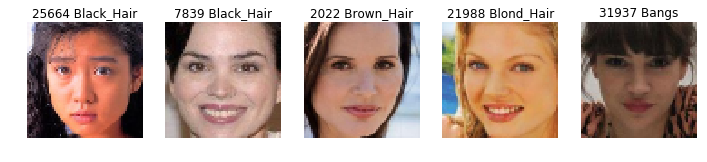

In [6]:
k = 5
idx = np.random.choice(40000 , size=k)

fig = plt.figure(figsize=(2*k+2,3))
for i,img_name in enumerate( idx ):
    ax = fig.add_subplot( 1,k , i+1 )
    ax.imshow( train_img[img_name].astype("int") )
    ax.axis("off")
    a = np.argmax(train_attribute[img_name])
    
    ax.set_title(str(img_name)+" "+attr[a])
plt.show()


In [7]:
processing_input = lambda x : (x/255-0.5)*2
inverse_processing = lambda x : (x/2+0.5)*255

In [8]:
train_data = processing_input(train_img)

### Build Model

In [36]:
tf.reset_default_graph()
VAE_graph = tf.Graph()

In [37]:
def reconstruct_layer(inputs , tr=True):
    x = ly.fully_connected(inputs , 2048 , trainable=tr 
                           , reuse=tf.AUTO_REUSE , scope="fc_1")
    x = tf.reshape( x , shape=[-1,1,1,2048] )

    x = ly.conv2d_transpose(x , 512 , [2,2] , padding="VALID" , trainable=tr
                            , reuse=tf.AUTO_REUSE , scope="Conv2DT_1")
    x = ly.conv2d_transpose(x , 256 , [5,5] , padding="VALID" , trainable=tr
                            , reuse=tf.AUTO_REUSE , scope="Conv2DT_2")
    x = ly.batch_norm(x , reuse=tf.AUTO_REUSE , trainable=tr , scope="bc_1")
    x = ly.conv2d_transpose(x , 128 , [6,6] , stride=[2,2] , padding="VALID" 
                            , trainable=tr , reuse=tf.AUTO_REUSE , scope="Conv2DT_3")

    x = ly.batch_norm(x , reuse=tf.AUTO_REUSE , scope="bc_2")
    x = ly.conv2d_transpose(x , 64 , [9,9] , stride=[4,4] , padding="SAME" 
                            , trainable=tr , reuse=tf.AUTO_REUSE , scope="Conv2DT_4")

    out = ly.conv2d(x , 3 , [1,1] , padding="VALID" , activation_fn=tf.nn.tanh 
                    , trainable=tr , reuse=tf.AUTO_REUSE , scope="To_rgb")
    return out
        

In [38]:
with VAE_graph.as_default():
    latent_dim = 1024
    
    with tf.name_scope("Input"):
        img = tf.placeholder( shape=[None , 64,64,3] , dtype=tf.float32 )
    
    with tf.name_scope("Encode"):
        with tf.name_scope("block1"):
            _ = ly.conv2d( img , 64 , [5,5] , padding="VALID" )
            _ = ly.conv2d( _ , 96 , [3,3] , padding="VALID" )
            block_1 = ly.avg_pool2d( _ , [3,3] , stride=[2,2] , padding="VALID" )
            
        with tf.name_scope("block2"):
            _ = ly.batch_norm(block_1)
            _ = ly.conv2d( _ , 96 , [3,3] , padding="VALID" )
            _ = ly.conv2d( _ , 128 , [3,3] , padding="VALID" )
            block_2 = ly.max_pool2d( _ , [3,3] , stride=[2,2] , padding="VALID" )
            
        with tf.name_scope("block3"):
            _ = ly.batch_norm(block_2)
            _ = ly.conv2d( _ , 128 , [3,3] , padding="VALID" )
            _ = ly.conv2d( _ , 256 , [1,1] , padding="VALID" )
            _ = ly.conv2d( _ , 256 , [3,3] , padding="VALID" )
            block_3 = ly.avg_pool2d( _ , [2,2] , stride=[1,1] , padding="VALID" )
        
        with tf.name_scope("block4"):
            _ = ly.batch_norm(block_3)
            _ = ly.conv2d( _ , 512 , [3,3] , stride=[2,2] , padding="VALID" )
            block_4 = ly.conv2d( _ , 2048 , [2,2] , padding="VALID" )
        
        flat_code = tf.reshape( block_4 , shape=[-1,2048] , name="flat")
        
    with tf.name_scope("z_code"):
        z_mean = ly.fully_connected(flat_code , latent_dim , activation_fn=tf.nn.tanh , scope="z_mean")
        z_log_var = ly.fully_connected(flat_code , latent_dim , activation_fn=tf.nn.leaky_relu , scope="z_log_var")
    
    with tf.name_scope("Sampling"):
        epsi = tf.random_normal( shape=tf.shape(z_log_var) )
        z = z_mean + epsi*tf.exp(z_log_var/2)

    with tf.variable_scope("shared_decoder"):
        with tf.name_scope("Decode"):
            img_reconstruct = reconstruct_layer(z)
    
    with tf.variable_scope("shared_decoder" , reuse=True):
        with tf.name_scope("Infer"):
            Infer_img = reconstruct_layer(z_mean , tr=False )
    ## Assign random vector to z 
    with tf.variable_scope("shared_decoder" , reuse=True):
        with tf.name_scope("random_infer"):
            random_z = tf.placeholder(shape=[None,latent_dim] , dtype=tf.float32)
            Infer_by_random = reconstruct_layer(random_z , tr=False)
    
    with tf.name_scope("Loss"):
        with tf.name_scope("KL_loss"):
            kl_loss = -0.5*tf.reduce_sum( 1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var) ,axis=-1 )
            
            
        with tf.name_scope("MSE_loss"):
            dim = 1
            for d in img.shape[1::]:
                dim *= int(d)
            mse_loss = tf.reduce_mean(  tf.reshape(tf.square(img - img_reconstruct) , [-1,dim]),axis=-1)
            
    
        loss = tf.reduce_mean(mse_loss+5e-5*kl_loss)
    tf.summary.scalar("Loss/KL_loss" , tf.reduce_mean(kl_loss))  
    tf.summary.scalar("Loss/MSE_loss" , tf.reduce_mean(mse_loss))
    tf.summary.scalar("Total_loss" , loss)
    
    with tf.name_scope("Train_strategy"):
        decay_policy = tf.train.exponential_decay(2e-4 , decay_rate=0.9 , decay_steps=4000 , global_step=1000)
        opt_operation = tf.train.AdamOptimizer(learning_rate=decay_policy).minimize(loss)
        
        second_opt_operation = tf.train.AdamOptimizer(1e-6).minimize(loss)
    
    init = tf.global_variables_initializer()
    
    merged_log = tf.summary.merge_all()
    VAE_writer = tf.summary.FileWriter("tb_logs/VAE_ver0" , graph=VAE_graph)
    
    saver = tf.train.Saver()
    
        

In [1]:
sess = tf.Session(graph=VAE_graph , config=gpu_opt)
sess.run( init )

NameError: name 'tf' is not defined

In [ ]:
n_epoch = 500
n_batch = 200

n_step = train_data.shape[0]//n_batch
# s = 0
r_index = np.arange( train_data.shape[0] )
history = []
step_kl_loss = []
step_xmse_loss = []
for e in range(n_epoch):
    start_time = time.time()
    np.random.shuffle( r_index )
    data_x = train_data[r_index]
    start = 0
    print( "Epoch {0:4d}/{1}".format( e+1 , n_epoch ) )
    l_e = 0
    for step in range(n_step):
        print( "[{0:-<30}]".format( "="*((step+1)*30//n_batch) ) , end="\r" )
        data_config = { img:data_x[start:start+n_batch]}
        s+=1
        summary , l , _ = sess.run([ merged_log , loss , opt_operation ], feed_dict=data_config )
        if (s%10) ==0 :
            VAE_writer.add_summary(summary , s)
        l_e += l*n_batch/train_data.shape[0]
        
        start+=n_batch
        
    
    print("[{0:-<30}] loss: {1:.5f}  time: {2:.1f}".format( "="*((step+1)*30//n_batch) , l_e , time.time()-start_time))
        
    

Epoch    1/500
[==============================] loss: 0.02106  time: 55.0
Epoch    2/500
[==============================] loss: 0.02108  time: 34.9
Epoch    3/500
[==============================] loss: 0.02101  time: 34.9
Epoch    4/500
[==============================] loss: 0.02102  time: 34.4
Epoch    5/500
[==============================] loss: 0.02096  time: 34.4
Epoch    6/500
[==============================] loss: 0.02098  time: 34.4
Epoch    7/500
[==============================] loss: 0.02093  time: 34.4
Epoch    8/500
[==============================] loss: 0.02101  time: 34.4
Epoch    9/500
[==============================] loss: 0.02097  time: 34.4
Epoch   10/500
[==============================] loss: 0.02092  time: 34.4
Epoch   11/500
[==============================] loss: 0.02093  time: 34.5
Epoch   12/500
[==============================] loss: 0.02095  time: 34.4
Epoch   13/500
[==============================] loss: 0.02090  time: 34.4
Epoch   14/500
[======================

Epoch  112/500
[==============================] loss: 0.02028  time: 34.3
Epoch  113/500
[==============================] loss: 0.02025  time: 34.3
Epoch  114/500
[==============================] loss: 0.02026  time: 34.3
Epoch  115/500
[==============================] loss: 0.02030  time: 34.3
Epoch  116/500
[==============================] loss: 0.02028  time: 34.3
Epoch  117/500
[==============================] loss: 0.02030  time: 34.3
Epoch  118/500
[==============================] loss: 0.02027  time: 34.3
Epoch  119/500
[==============================] loss: 0.02025  time: 34.3
Epoch  120/500
[==============================] loss: 0.02022  time: 34.3
Epoch  121/500
[==============================] loss: 0.02026  time: 34.3
Epoch  122/500
[==============================] loss: 0.02023  time: 34.3
Epoch  123/500
[==============================] loss: 0.02018  time: 34.4
Epoch  124/500
[==============================] loss: 0.02023  time: 34.4
Epoch  125/500
[======================

In [44]:
saver.save(sess,"model_para/VAE-ver0")

'model_para/VAE-ver0'

In [48]:
i = 10
test1 = sess.run( Infer_img , feed_dict={img:train_data[i:i+2]} )
test1 = inverse_processing(test1)

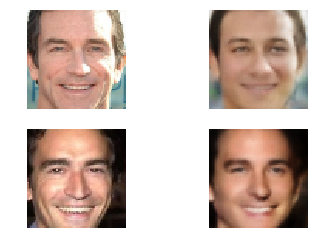

In [54]:
fig , ((ax1 , ax2) ,( ax3 , ax4)) = plt.subplots(2,2)

ax1.imshow(train_img[i].astype("int"))
ax1.axis("off")

ax2.imshow(test1[0].reshape(64,64,3).astype("int"))
ax2.axis("off")

ax3.imshow(train_img[i+1].astype("int"))
ax3.axis("off")

ax4.imshow(test1[1].reshape(64,64,3).astype("int"))
ax4.axis("off")

plt.show()

In [139]:
random_img = sess.run( Infer_by_random , feed_dict={random_z:np.random.randn(1,latent_dim)} )

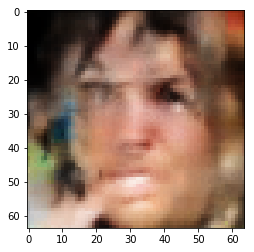

In [140]:
plt.imshow(inverse_processing(random_img.reshape(64,64,3)).astype("int"))